## TCRE Analysis

Here is some code that uses xarray to open ESM4 data, calculate global averages for surface warming, and plot the relationship between surface warming and emissions

Exercise in looking at internal ESM4 output/naming conventions/jupyter notebook creation


Written by Katherine Turner, 05 Jan 2023

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fpath = '/Users/keturner/TCRE/ESM4_1pctCO2_D1/gfdl.ncrc4-intel16-prod-openmp/pp/'
vpath = 'ts/monthly/5yr/'

In [3]:
#atmos.static.nc contains constant fields for atmospheric variables - area, orography, etc.

adata = xr.open_dataset(f'{fpath}atmos/atmos.static.nc')
adata

<xarray.Dataset>
Dimensions:      (scalar_axis: 1, lev: 49, nv: 2, phalf: 50, lat: 180,
                  lon: 288, bnds: 2)
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * lev          (lev) float64 0.998 0.9928 0.9854 ... 3.934e-05 1.849e-05
  * nv           (nv) float64 1.0 2.0
  * phalf        (phalf) float64 0.01 0.02697 0.05171 ... 989.7 995.9 1e+03
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * bnds         (bnds) float64 1.0 2.0
Data variables: (12/18)
    p500         (scalar_axis) float64 ...
    p850         (scalar_axis) float64 ...
    height10m    (scalar_axis) float64 ...
    height2m     (scalar_axis) float64 ...
    ap           (lev) float64 ...
    ap_bnds      (lev, nv) float64 ...
    ...           ...
    lat_bnds     (lat, bnds) float64 ...
    lon_bnds     (lon, bnds) float64 ...
    orog         (lat, lon) float32 ...
    sftlf        (lat, lon) float32 ...
    land_mask    (lat, lon) float32 ...
    zsurf        (lat, lon) float32 ...
Attributes:
    external_variables:  ps ps

In [4]:
# open files for global temperatures
# for now, I don't have preindustrial averages so I won't take any difference
# I'm just focusing on calculating annual averages and global averages at this point

ds1 = xr.open_mfdataset(f"{fpath}atmos/{vpath}/atmos.*")
ds1.t_ref

/Users/keturner/opt/anaconda3/envs/TCRE/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.DataArray 't_ref' (time: 1800, lat: 180, lon: 288)>
dask.array<concatenate, shape=(1800, 180, 288), dtype=float32, chunksize=(60, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
Attributes:
    long_name:      temperature at 2 m
    units:          deg_k
    valid_range:    [100. 400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [5]:
# Need to create annual averages from monthly average data -- first calculate weights for each month
month_length = ds1.time.dt.days_in_month
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
wgts

<xarray.DataArray 'days_in_month' (time: 1800)>
array([0.08493151, 0.07671233, 0.08493151, ..., 0.08493151, 0.08219178,
       0.08493151])
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
    year     (time) int64 1 1 1 1 1 1 1 1 1 ... 150 150 150 150 150 150 150 150

In [6]:
wgts.groupby("time.year").sum(xr.ALL_DIMS) # double check that the weights are correct for each year

<xarray.DataArray 'days_in_month' (year: 150)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 143 144 145 146 147 148 149 150

In [7]:
annavg_num = (ds1["t_ref"]*wgts).resample(time="AS").sum(dim="time")
annavg_den = wgts.resample(time="AS").sum(dim="time")

t_ref_ann = annavg_num / annavg_den
t_ref_ann

<xarray.DataArray (time: 150, lat: 180, lon: 288)>
dask.array<truediv, shape=(150, 180, 288), dtype=float64, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-01-01 00:00:00 ... 0150-01-01 00:00:00

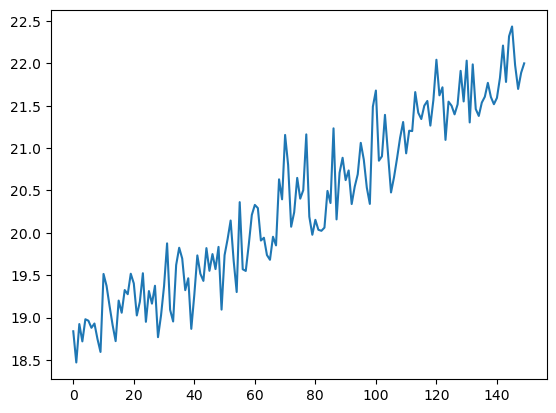

In [8]:
plt.plot(t_ref_ann[:,121,270].data - 273.15) # looks good! 

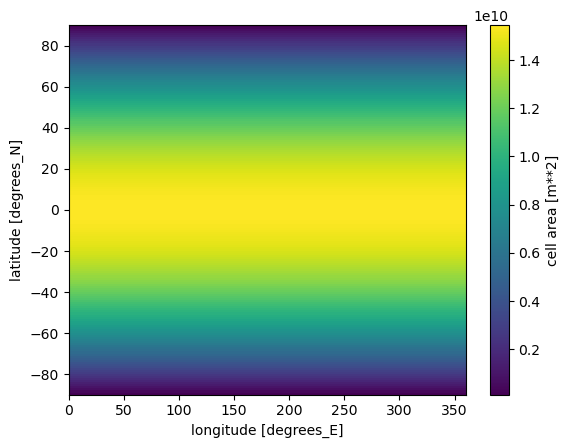

In [9]:
# moving on to global averages. We have the area of each grid cell in that atmos file we first opened
adata.area.plot()

In [10]:
aweights = adata.area/adata.area.sum()
# aweights

<xarray.DataArray 'area' (lat: 180, lon: 288)>
array([[2.2882223e-07, 2.2882223e-07, 2.2882223e-07, ..., 2.2882223e-07,
        2.2882223e-07, 2.2882223e-07],
       [7.7674559e-07, 7.7582843e-07, 7.7490171e-07, ..., 7.7943974e-07,
        7.7855123e-07, 7.7765321e-07],
       [1.3107064e-06, 1.3107108e-06, 1.3107153e-06, ..., 1.3106931e-06,
        1.3106974e-06, 1.3107018e-06],
       ...,
       [1.3107064e-06, 1.3107108e-06, 1.3107153e-06, ..., 1.3106931e-06,
        1.3106974e-06, 1.3107018e-06],
       [7.7674559e-07, 7.7582843e-07, 7.7490171e-07, ..., 7.7943974e-07,
        7.7855123e-07, 7.7765321e-07],
       [2.2882223e-07, 2.2882223e-07, 2.2882223e-07, ..., 2.2882223e-07,
        2.2882223e-07, 2.2882223e-07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [20]:
# aweights.sum() # there is a rounding error - answer is 0.99999999 - but should be OK? Maybe?

In [12]:
temp_weighted = t_ref_ann.weighted(aweights)
temp_weighted

DataArrayWeighted with weights along dimensions: lat, lon

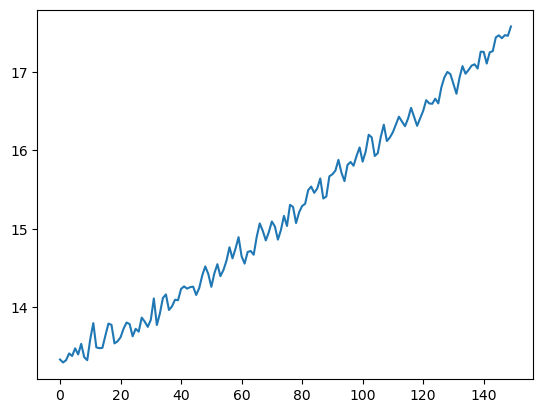

In [13]:
temp_glob = temp_weighted.mean(("lat", "lon"))
plt.plot(temp_glob.data-273.15)

In [28]:
# open files for carbon fluxes

ds2 = xr.open_mfdataset(f"{fpath}atmos_co2_level/{vpath}/atmos*")
ds2.co2_mol_flux

/Users/keturner/opt/anaconda3/envs/TCRE/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.DataArray 'co2_mol_flux' (time: 1800, lat: 180, lon: 288)>
dask.array<concatenate, shape=(1800, 180, 288), dtype=float32, chunksize=(60, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
Attributes:
    long_name:      flux of carbon dioxide
    units:          mol CO2/(m2 s)
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

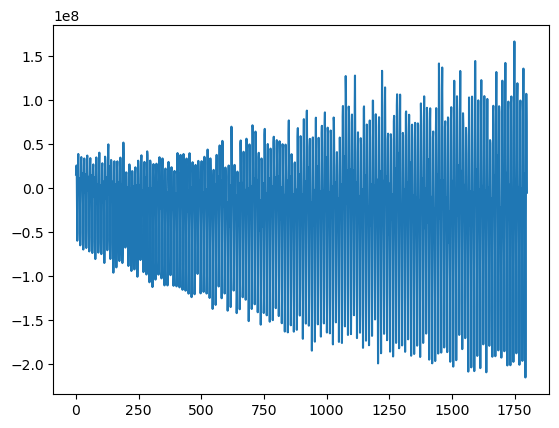

In [40]:
flux_glob = (ds2.co2_mol_flux*adata.area).sum(("lat", "lon"))
plt.plot(flux_glob.data)

In [45]:
# now we have to sum up cumulatively to find total changes in combined land and ocean inventories
# caveats -- I'm assuming we don't need to re-sample fluxes at 1st or end of the month (not sure about this)
# and we are straight ignoring sediment carbon release

# output is in m-2 s-1 - for our global integral we now have s-1

day2sec = 24*60**2
mol2PgC = 12.011*1e-15

sink_LO = (flux_glob*month_length*day2sec).cumsum(dim="time")
sink_LO

<xarray.DataArray (time: 1800)>
dask.array<nancumsum, shape=(1800,), dtype=float64, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00

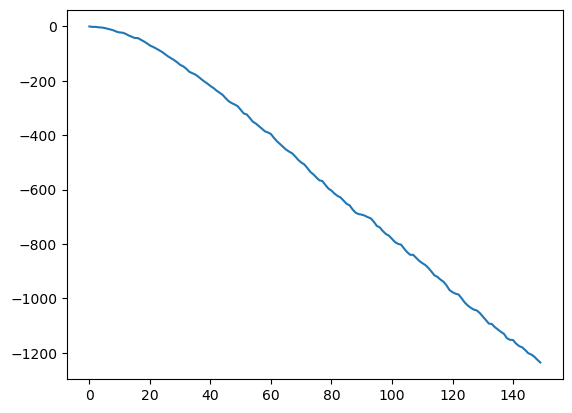

In [46]:
plt.plot(sink_LO[5::12].data*mol2PgC)

In [54]:
test = sink_LO[5::12].data*mol2PgC

In [59]:
test[80].compute()

-603.6812691875612